# Cheat sheet de estadística para ciencia de datos

In [18]:
import numpy as np

def simulations(distribution, mu = None, std = None, size = 1000):
    if distribution == 'normal':
        return np.random.normal(loc = mu, scale= std, size = size)    

## Probabilidad 

### Teorema de Bayes

#### Probabilidad condicional

##### Ejemplos típicos

## Distribuciones típicas

### Discretas

### Continuas


## Análisis de significancia

#### ANOVA:

##### ANOVA: Efectos fijos

##### ANOVA: Efectos aleatorios

#### Análisis de la covarianza (ANCOVA):


## Análisis multifactorial:


## Tests clásicos

#### AB Testing

A\B Testing is a classical methods to assay a control/test procedure. In these problems we typically have two ways to solve a problem A and B we split the data in $data_A$ and $data_B$ and we get some statistics of interest for each method. 

Let's create a synthetic example, we want to assay an "improvement" in a drug to cure a virus. To do so we split our patients in two groups:
* Group A - traditional  (500 patients)
* Group B - new drug (500 patients)
We measure the effectiveness of the drug we measure the amount of time each patient takes to recover.

In [33]:
import scipy
import numpy as np
import pandas as pd

# Reproducibility (MLOps)
SEED = 6543210
np.random.seed(SEED)

n_a, n_b = 100, 100
mu_a, sigma_a = 10, 5
mu_b, sigma_b = 8,5.5
patients_a = list(np.random.normal(mu_a, sigma_a, n_a))
patients_b = list(np.random.normal(mu_b, sigma_b, n_b))
patients = ['A']*n_a+['B']*n_b
df = pd.DataFrame(zip(patients, patients_a+patients_b), columns = ['patients','recovery_time'])
df.head()

,patients,recovery_time
0,A,7.928130
1,A,10.938724
2,A,2.959062
3,A,12.184544
4,A,17.253185


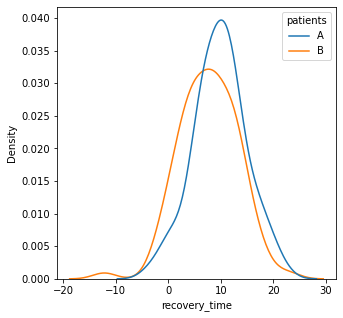

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (5,5))
sns.kdeplot(x = 'recovery_time', data = df, hue = 'patients')
plt.show()

From here we know clearly that there are some differences. Clearly the drug $B$ has less recovery time while $A$ has less desviation. However, a plot is not a proff or anything, we need some rigor to be able to say that there is a significant improvement.

To perform the A\B testing we need to establish the test:
$$H_0:d = \mu_a - \mu_b = 0$$
$$H_1:d = \mu_a - \mu_b = 0$$
That is $\hat{d}\sim \mathcal{N}(0, \sigma_d)$ under $H_0$ and $\hat{d} \sim \mathcal{N}(d,\sigma_d)$ under $H_1$, where $\hat{d}$ follows the distribution given by $\frac{\sum_{i = 1}^Nd_i}{N}$. For this, we can apply the CLT or Central Limit Theorem which says that given a set of $N$ iid random variables $X_i$ (all of them with the same number of examples in this case, if the number of examples is different then we need to use $\frac{1}{n\cdot m}\sum_{i=1}^n\sum_{j = 1}^mX_{ij}$), the sum of them can be estimated as a $\mathcal{N}(\sum_{i = 1}^N\overline{X}/N, \sqrt{\sum_{i = 1}^N \sigma_i^2}/\sqrt{N})$ where under the condition of $H_0$ $\sigma_i = \sigma_{i+1}, \forall 1 \leq i \leq N$ thus $\sigma_i = \sigma_d$.

NOTE: If our distribution is not $\mathcal{N}$ but any other like binomial, Poisson, negative binomial $\gamma$ and so on, we have to remember that we are using the CLT and it applies to all of them equally. Therefore, the only thing that changes is the way we get the means and the desviations, for example:
* Binomial: imagina $Y$ is $0$ or $1$ meaning the patient dies or survives. In this case, $\mu = p$ and $\sigma_i = p(1-p)$ because each is a Bernoulli event, and what are we trying to measure is the number of survivals given a rate $p$. Therefore, we have the control rate $p_a$ and the new drug rate $p_b$. Everything goes equal and the mean $\mu_a = n_a\cdot p_a$ and $\mu_b = n_b \cdot p_b$ and $\sigma_a = p_a(1 - p_a)$ and $\sigma_b = p_b(1 - p_b)$. Because, CLT we know that $\sum_i X_i$ when $X_i \in Bi(n, p), ~\forall 1 \leq i \leq N$ then when $N \to \infty,~\overline{X} \sim \mathcal{N}(\frac{\sum_i \mu_i}{N}, \sqrt{\frac{\sigma_i^2}{N}})$
* $\dots$
But what is the point of all of this? Are we goint to repeat the test $\infty$ times until we can say this with confidence?. No of course not.

What this is saying is:***If $H_0$ occurs then if we repeat the experiment $\infty$ times we will get $\mathcal{N}(\mu, \sigma)$ with both paramenters known. Therefore, if $\hat{d} \sim \mathcal{N}$ we can measure $P(d \leq X)$, in other words we can get the probability of our $d$ to be significant and to see if we have to accept or reject $H_0$***

Let's continue with the code:
* Get empirial means
* Get empirical standard deviations

In [35]:
df_agg = df.groupby('patients').agg({'recovery_time':['mean','std']}).reset_index()
df_agg.head()

patients recovery_time          
                    mean       std
0        A      9.762944  5.020057
1        B      7.688008  5.529326

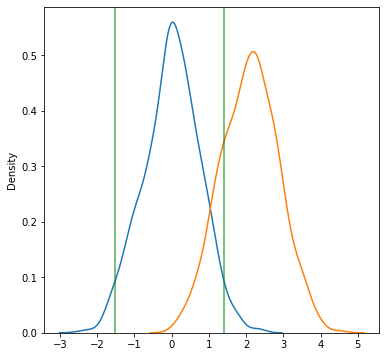

In [45]:
sd_a, sd_b = df_agg.iloc[0][('recovery_time', 'std')], df_agg.iloc[1][('recovery_time', 'std')]
mean_a, mean_b = df_agg.iloc[0][('recovery_time', 'mean')], df_agg.iloc[1][('recovery_time', 'mean')]
mean_h0, std_h0 = 0, np.sqrt(sd_a**2/n_a + sd_b**2/n_b)
mean_h1, std_h1 = mean_a - mean_b, np.sqrt(sd_a**2/n_a + sd_b**2/n_b)
sample_h0, sample_h1 = simulations(distribution='normal', mu = mean_h0, std = std_h0),simulations(distribution='normal', mu = mean_h1, std = std_h1)
q_025, q_975 = np.quantile(sample_h0,q = 0.025), np.quantile(sample_h0, q = 0.975)
fig, ax = plt.subplots(figsize = (6,6))
sns.kdeplot(sample_h0, ax = ax)
sns.kdeplot(sample_h1, ax = ax)
### Vertical lines
ax.axvline(x = q_025, ymin = 0.0, ymax=2.0, linewidth=2, alpha=0.5,color='g')
ax.axvline(x = q_975, ymin = 0.0, ymax=2.0, linewidth=2, alpha=0.5,color='g')


As we can see in the above figure there is a shared region between the two distributions (ditribution for $H_0$ and for $H_1$). That shared regions allows us to get the power of our test. We can define the power of the test as the area under the density function under $H_1$ out of the confidence interval of $H_0$. That is:
$$Power(T) = \int_{\mathcal{D}'} f_{h_1}(x)$$
where $\mathcal{D}' = \mathcal{D} \setminus ((-\infty,q_{\alpha}] \cup [q_{1-\alpha,\infty)}) \subset \mathcal{D}$, with $\alpha$ defined for $H_0$.

Here we can explain four important elements in hipothesis tests:
* $\beta$ or false negative probability, type II error, accept $H_0$ when it is not correct.
* $1-\beta$ or power, is the probability correctly reject $H_0$.
* $\alpha$, significance or false positive, probability of reject $H_0$ wrong.
* $1 - \alpha$, true negative accept $H_0$ correctly.

Now, how can we measure the power of our test, how can we measure $1-\beta$, simply $1 - \beta = P(X_{H_1} > x_{\alpha}) = 1 - P(X_{H_1} \leq x_{\alpha}$, where $\alpha = P(X_{H_0} > x_{\alpha})$. Therefore, getting the EDF, empirical distribute function or parametrically using $\mathcal{N}(\hat{d}, \sigma)$ we can get that probability and the power of the test.

#### Test de medias

#### Test $\chi^2$

#### Test $t$-student

## Test no paramétricos:

##### Kolmogorov Smirnoff (lilliefors correction)

##### Basados en momentos:

###### Dagostino Pearson

###### Jarque Bera

#### Kruskal-Wallis

#### Friedman

#### Prueba de rachas de Walt-Wolfowitz

#### Test de wilcoxon

## Diseño de experimentos (DOE - Design of experiments)